# Pneumonia Pre-Processing and Modeling

## Import Revelant Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import backend as K

## Import Data

In [2]:
df_train = pd.read_pickle('Clean_Data/training_data.csv')
df_test = pd.read_pickle('Clean_Data/testing_data.csv')
df_val = pd.read_pickle('Clean_Data/validation_data.csv')

## Explore Data

In [3]:
print(df_train.head(1))
print(df_test.head(1))
print(df_val.head(1))

                                               Image   Label
0  [[29, 27, 30, 28, 27, 26, 28, 29, 30, 29, 28, ...  Normal
                                               Image   Label
0  [[25, 24, 21, 19, 19, 21, 20, 21, 20, 20, 20, ...  Normal
                                               Image   Label
0  [[6, 23, 32, 30, 40, 37, 44, 43, 40, 38, 39, 4...  Normal


In [4]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5216, 2)
(624, 2)
(16, 2)


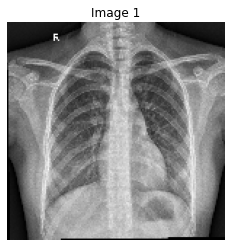

In [5]:
_ = plt.imshow(df_train['Image'][0], cmap='gray')
_ = plt.axis('off')
_ = plt.title('Image 1')

In [6]:
df_train['Image'][0].shape

(150, 150)

## Preprocess Data

### Equalize Images

In [7]:
def equalize(image_list):
    im_equalized = []
    for im in image_list.index:
        hist = ndi.histogram(image_list[im], min=0, max=255, bins=256)
        cdf = hist.cumsum() / hist.sum()
        im_equalized.append(cdf[image_list[im]] * 255)
    return im_equalized

In [8]:
df_train['Equalize_Image'] = equalize(df_train['Image'])
df_test['Equalize_Image'] = equalize(df_test['Image'])
df_val['Equalize_Image'] = equalize(df_val['Image'])

### Split Data & Reshape

In [9]:
X_train = df_train['Equalize_Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_train = np.concatenate(X_train).reshape(X_train.shape[0], X_train[0].shape[0], X_train[0].shape[1])
X_train = np.expand_dims(X_train, axis=-1) # Add forth dimension for color channel
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_train = df_train['Label'].replace(['Pneumonia', 'Normal'],[1,0])

X_test = df_test['Equalize_Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_test = np.concatenate(X_test).reshape(X_test.shape[0], X_test[0].shape[0], X_test[0].shape[1])
X_test = np.expand_dims(X_test, axis=-1) # Add forth dimension for color channel
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_test = df_test['Label'].replace(['Pneumonia', 'Normal'],[1,0])

X_val = df_val['Equalize_Image']
# Reshape image array so 4D (Number of Images, Image Width, Image Height, Color Channels)
X_val = np.concatenate(X_val).reshape(X_val.shape[0], X_val[0].shape[0], X_val[0].shape[1])
X_val = np.expand_dims(X_val, axis=-1) # Add forth dimension for color channel
# Replace string labels with numeric (Pneumonia = 1, Normal = 0)
y_val = df_val['Label'].replace(['Pneumonia', 'Normal'],[1,0])

In [10]:
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)
print('Validation data shape : ', X_val.shape, y_val.shape)

Training data shape :  (5216, 150, 150, 1) (5216,)
Testing data shape :  (624, 150, 150, 1) (624,)
Validation data shape :  (16, 150, 150, 1) (16,)


### Data Augmentation

To avoid overfitting data due to small image set.
- Randomly flip horizontally
- Randomly rotate by 5%
- Randomly vary height by 10%
- Randomly vary width by 10%

In [11]:
# Augment images to randomly: flip horizontally, rotate 5%, vary height 10%, and vary width 10%
data_augmentation = keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomHeight((-0.1,0.1)), 
     layers.experimental.preprocessing.RandomWidth((-0.1,0.1))
    ])

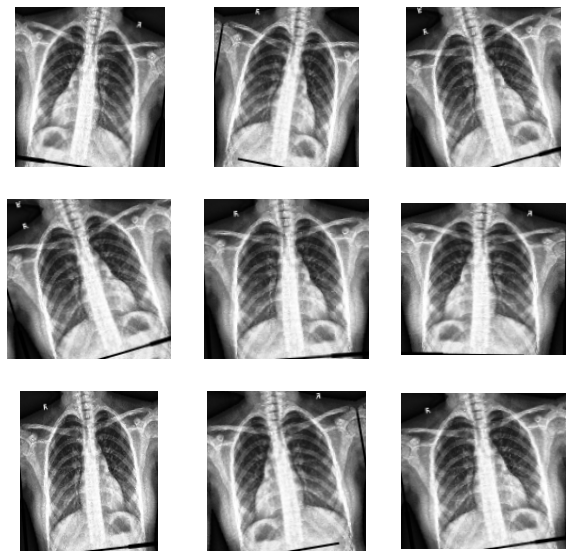

In [12]:
# Visualize 9 augmented samples on image 1
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_images = data_augmentation(X_train)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'), cmap='gray')
    plt.axis('off')

## Make Model

### Standardize

Training on GPU so will augment on device, synchronously with the rest of model execution.

Data augmentation inactive at test time, input samples will only be augmented during fit.

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, (3,3), padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, (3,3), padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D((3,3), strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, (1,1), strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

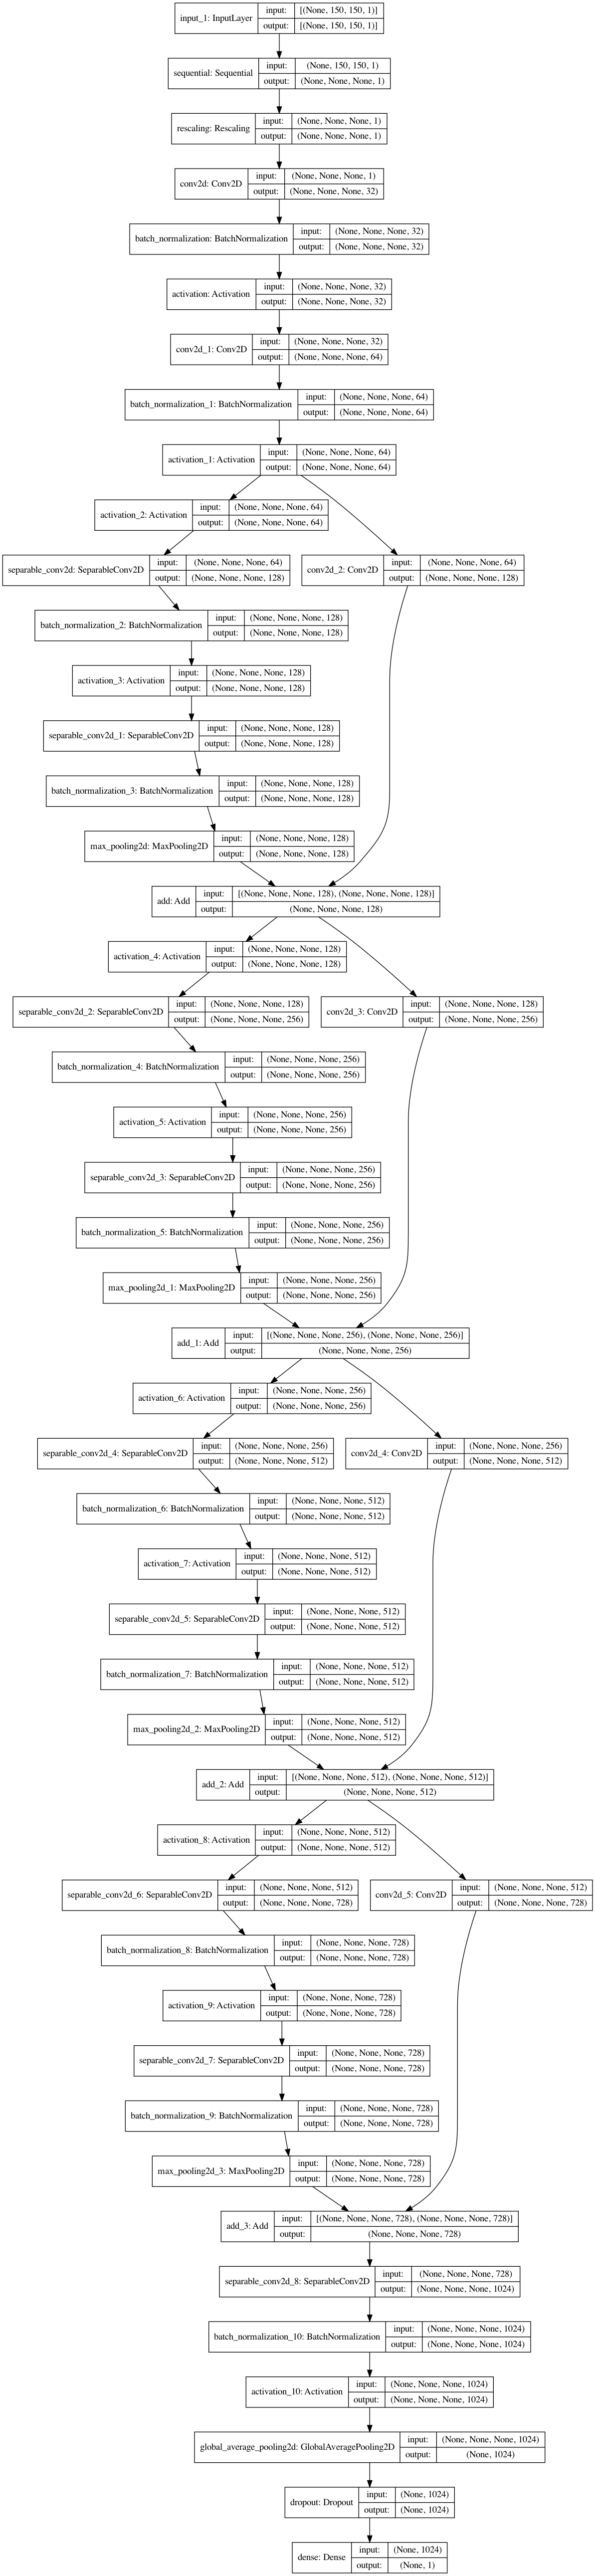

In [14]:
image_size = X_train.shape[1:]
model = make_model(input_shape=image_size, num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train Model

In [15]:
# Define recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Define precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Define F1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc", f1_m, precision_m, recall_m])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 1 0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         rescaling[0][0]                  
______________________________________________________________________________________________

In [17]:
history = model.fit(x=X_train, y=y_train, epochs=12, validation_data=(X_val, y_val))

Epoch 1/12
163/163 [==============================] - 401s 2s/step - loss: 0.2663 - acc: 0.8823 - f1_m: 0.9188 - precision_m: 0.9198 - recall_m: 0.9229 - val_loss: 2.8580 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 2/12
163/163 [==============================] - 1200s 7s/step - loss: 0.1371 - acc: 0.9469 - f1_m: 0.9644 - precision_m: 0.9619 - recall_m: 0.9691 - val_loss: 4.7184 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 3/12
163/163 [==============================] - 431s 3s/step - loss: 0.1231 - acc: 0.9505 - f1_m: 0.9663 - precision_m: 0.9637 - recall_m: 0.9714 - val_loss: 4.1517 - val_acc: 0.5000 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 4/12
163/163 [==============================] - 438s 3s/step - loss: 0.1242 - acc: 0.9504 - f1_m: 0.9659 - precision_m: 0.9626 - recall_m: 0.9713 - val_loss: 0.4738 - val_acc: 0.8125 - val_f1_m: 0.8235 - val_precision_m: 0

## Evaluate Model Performance

In [18]:
# Evaluate model performance using test data
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)

20/20 [==============================] - 16s 813ms/step - loss: 1.0293 - acc: 0.6426 - f1_m: 0.3963 - precision_m: 0.6500 - recall_m: 0.2875


In [19]:
# Print evaluation results
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Loss: 1.0292986631393433
Accuracy: 0.6426281929016113
F1 Score: 0.39626505970954895
Precision: 0.6499999761581421
Recall: 0.2874999940395355
